In [1]:
import torch
import drlqap.nn
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
n = 8
w = 8

tensor(0.5093)


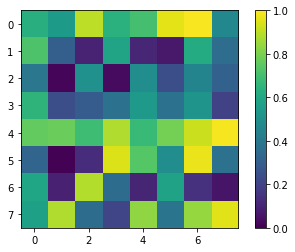

In [4]:
input_matrix = torch.rand((n, n))
print(input_matrix.mean())
plt.imshow(input_matrix, vmin=0, vmax=1)
plt.colorbar()

tensor(0.4880)


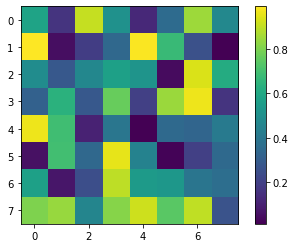

In [5]:
output_matrix = torch.rand((n, w))
print(output_matrix.mean())
plt.imshow(output_matrix)
plt.colorbar()

In [6]:
class TwoLayers(torch.nn.Module):
    def __init__(self, norm):
        super().__init__()
        
        norm_layer = lambda x: x
        if norm == "per_node":
            norm_layer = torch.nn.LayerNorm(w)
        elif norm == "global":
            norm_layer = torch.nn.Sequential(
                torch.nn.LayerNorm((n, w), elementwise_affine=False),
                torch.nn.Linear(w, w)
            )
        elif norm is not None:
            raise AttributeError(f"Invalid norm {norm}")
        
        self.layer1 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1, w, w, 3, activation=torch.nn.Sigmoid, layer_norm=False),
            transformation = norm_layer,
            layer_norm = False,
        )
        
        self.layer2 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1+w, w, w, 3, activation=torch.nn.Sigmoid, layer_norm=False),
            transformation = norm_layer,
            layer_norm = False
        )
    
    def forward(self, e):
        x = self.layer1(e, None)
        x = self.layer2(e, x)
        return x

class TwoLayersInternalNorm(torch.nn.Module):
    def __init__(self, norm_encoders):
        super().__init__()
        
        self.layer1 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1, w, w, 2, activation=torch.nn.Sigmoid, layer_norm=norm_encoders),
            transformation = drlqap.nn.FullyConnected(w, w, w, 0, activation=torch.nn.Sigmoid, layer_norm=norm_encoders),
            layer_norm=True
        )
        
        self.layer2 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1+w, w, w, 2, activation=torch.nn.Sigmoid, layer_norm=norm_encoders),
            transformation = drlqap.nn.FullyConnected(w, w, w, 0, activation=torch.nn.Sigmoid, layer_norm=norm_encoders),
            layer_norm = True
        )
    
    def forward(self, e):
        x = self.layer1(e, None)
        x = self.layer2(e, x)
        return x

    
class TwoLayersInternalNormReLU(torch.nn.Module):
    def __init__(self, norm_encoders):
        super().__init__()
        
        self.layer1 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1, w, w, 2, activation=torch.nn.ReLU, layer_norm=norm_encoders),
            transformation = drlqap.nn.FullyConnected(w, w, w, 0, activation=torch.nn.ReLU, layer_norm=norm_encoders),
            layer_norm=True
        )
        
        self.layer2 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1+w, w, w, 2, activation=torch.nn.ReLU, layer_norm=norm_encoders),
            transformation = drlqap.nn.FullyConnectedLinearOut(w, w, w, 0, activation=torch.nn.ReLU, layer_norm=norm_encoders),
            layer_norm = True
        )
    
    def forward(self, e):
        x = self.layer1(e, None)
        x = self.layer2(e, x)
        return x
    
class TwoLayersInternalNormReLUDeep(torch.nn.Module):
    def __init__(self, norm_encoders):
        super().__init__()
        
        self.layer1 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1, w, w, 3, activation=torch.nn.LeakyReLU, layer_norm=norm_encoders),
            transformation = drlqap.nn.FullyConnected(w, w, w, 3, activation=torch.nn.LeakyReLU, layer_norm=norm_encoders),
            layer_norm=True
        )
        
        self.layer2 = drlqap.nn.ConvLayer(
            edge_encoder = drlqap.nn.FullyConnected(1+w, w, w, 3, activation=torch.nn.LeakyReLU, layer_norm=norm_encoders),
            transformation = drlqap.nn.FullyConnectedLinearOut(w, w, w, 3, activation=torch.nn.LeakyReLU, layer_norm=norm_encoders),
            layer_norm = True
        )
    
    def forward(self, e):
        x = self.layer1(e, None)
        x = self.layer2(e, x)
        return x

    
layers = {
    "internal LN": TwoLayersInternalNorm(norm_encoders=False),
    "internal+Encoder LN": TwoLayersInternalNorm(norm_encoders=False),
    "LN global": TwoLayers(norm="global"),
    "LN per node": TwoLayers(norm="per_node"),
    "ReLU LN": TwoLayersInternalNormReLU(norm_encoders=False),
    "Deep ReLU LN": TwoLayersInternalNormReLUDeep(norm_encoders=False),
    "no LN": TwoLayers(norm=None),
}

In [7]:
def train(net, epochs, *inputs, lr=0.01):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)   
    losses = []
    target = output_matrix
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(*inputs)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), target.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [8]:
losses = {}
for name, layer in layers.items():
    losses[name] = train(layer, 1000, input_matrix.unsqueeze(2), lr=0.01)
    print(f"{name} finished")

internal LN finished
internal+Encoder LN finished
LN global finished
LN per node finished
ReLU LN finished
Deep ReLU LN finished
no LN finished


internal LN 0.02159089967608452
internal+Encoder LN 0.02802378311753273
LN global 0.05658479034900665
LN per node 0.0345759317278862
ReLU LN 0.03759389370679855
Deep ReLU LN 6.454052225990381e-08
no LN 0.07480593770742416


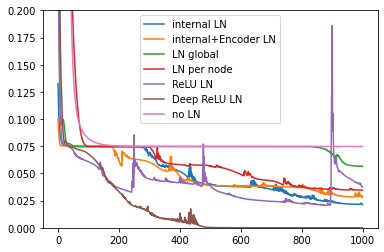

In [9]:
for name, loss in losses.items():
    print(name, loss[-1])
    plt.plot(loss, label=name)
plt.legend()
plt.ylim(top=0.2, bottom=0.0)
plt.show()

internal LN


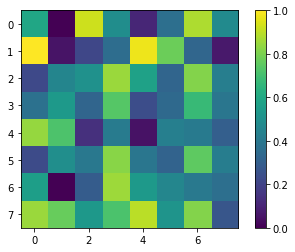

internal+Encoder LN


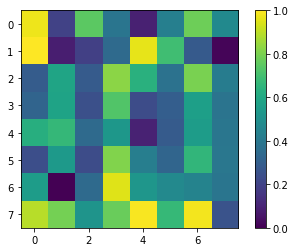

LN global


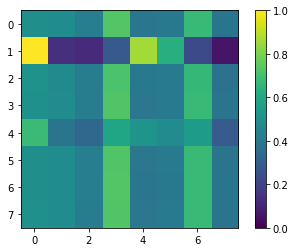

LN per node


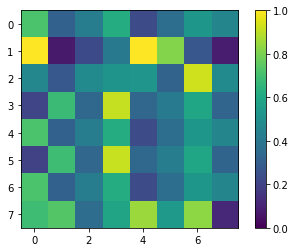

ReLU LN


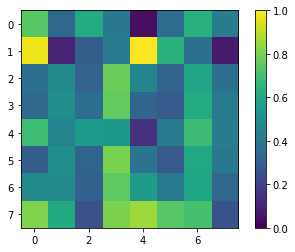

Deep ReLU LN


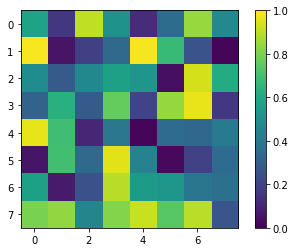

no LN


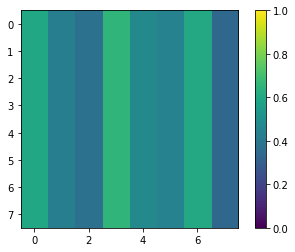

In [10]:
with torch.no_grad():
    for name, layer in layers.items():
        print(name)
        plt.imshow(layer(input_matrix.unsqueeze(2)), vmin=0, vmax=1)
        plt.colorbar()
        plt.show()

Target


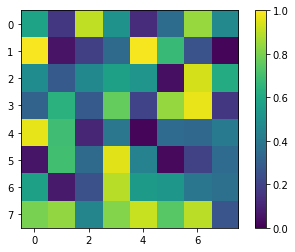

Mean


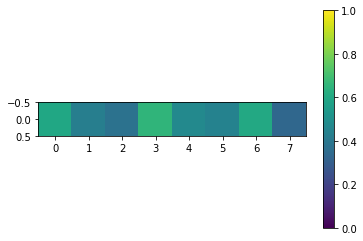

In [11]:
output_mean = torch.mean(output_matrix, dim=0, keepdims=True)
print("Target")
plt.imshow(output_matrix, vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Mean")
plt.imshow(output_mean, vmin=0, vmax=1)
plt.colorbar()
plt.show()